# 1. Import packages

In [1]:
import os
import pymysql
import pandas as pd
import sys

# Import package numpy for numeric computing
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Import package matplotlib for visualisation/plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#For showing plots directly in the notebook run the command below
%matplotlib inline

# 2. Connect to Amazon RDS

In [2]:
# Declare and initialize database connection credentials
host = 'dbbikes.cw9hkqmrhrqy.eu-west-1.rds.amazonaws.com'
user = 'root'
password = 'hanpeisong'
db = 'dbbikes'

# Attempt connection to database
# Print a statement on the screen to check whether the connection is working
try:
    con = pymysql.connect(host = host, user = user, password = password, db = db, use_unicode = True, charset = 'utf8')
    print('Connect to Database successfully.')
except Exception as e:
        sys.exit(e)

Connect to Database successfully.


# 3. Get Data

In [3]:
# Create dataframe and store data running SQL query
df_bike = pd.read_sql_query("select * from dbbikes.bike", con)

# Examine dataframe object, show first 10 rows
df_bike.head(10)

,id,station_id,status,bike_stands,available_bike_stands,available_bikes,last_update
0,1,42,OPEN,30,26,4,2020-02-27 14:05:02
1,2,30,OPEN,20,19,1,2020-02-27 14:08:49
2,3,54,OPEN,33,17,16,2020-02-27 14:08:41
3,4,108,OPEN,40,39,1,2020-02-27 14:06:33
4,5,56,OPEN,40,2,38,2020-02-27 14:09:31
5,6,6,OPEN,20,12,8,2020-02-27 14:01:55
6,7,18,OPEN,30,23,7,2020-02-27 14:09:39
7,8,32,OPEN,30,20,10,2020-02-27 14:09:10
8,9,52,OPEN,32,18,14,2020-02-27 14:02:05
9,10,48,OPEN,40,13,27,2020-02-27 14:08:43


In [4]:
# Create dataframe and store data running SQL query
df_weather = pd.read_sql_query("select * from dbbikes.weather", con)

# Examine dataframe object, show first 10 rows
df_weather.head(10)

,id,coord_lon,coord_lat,weather_id,weather_main,weather_description,weather_icon,base,main_temp,main_feels_like,...,sys_type,sys_id,sys_message,sys_country,sys_sunrise,sys_sunset,timezone,city_id,name,cod
0,2,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
1,3,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
2,4,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
3,5,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.51,273.19,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
4,6,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.58,273.27,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
5,7,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.58,273.27,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
6,8,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.58,273.27,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
7,9,-6.27,53.34,803,Clouds,broken clouds,04n,stations,277.67,273.24,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
8,10,-6.27,53.34,500,Rain,light rain,10d,stations,279.58,272.44,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
9,11,-6.27,53.34,500,Rain,light rain,10d,stations,279.58,272.44,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200


# 3. Prepare Data

## 3.1. Remove the repetitive data

In [5]:
# Bikes data
df_bike['last_update'].describe().T
df_bike.drop_duplicates(subset=['last_update'], keep='first', inplace=True)
df_bike['last_update'].describe().T
# Weather data
df_weather['dt'].describe().T
df_weather.drop_duplicates(subset=['dt'], keep='first', inplace=True)
df_weather['dt'].describe().T
df_bike.shape

(38022, 7)

## 3.2. Merge the bikes and weather dataframes

In [6]:
df_bike.rename(columns={'last_update':'dt'}, inplace=True)
df_bike['dt_hour'] = df_bike['dt'].dt.hour
df_bike['dt_min'] = df_bike['dt'].dt.minute
df_bike['dt_date'] = df_bike['dt'].dt.date
# The day of the week with Monday=0, Sunday=6.
df_bike['dt_dayofweek'] = df_bike['dt'].dt.dayofweek
df_weather['dt_hour'] = df_weather['dt'].dt.hour
df_weather['dt_min'] = df_weather['dt'].dt.minute
df_weather['dt_date'] = df_weather['dt'].dt.date

In [7]:
# Merge dataframes
df_merged = pd.merge(df_bike, df_weather, on = ['dt_min', 'dt_date', 'dt_hour'], how = 'inner')
# Show first 2 scraps (oldest) for stations (113*2=226)
df_merged.dtypes

id_x                              int64
station_id                        int64
status                           object
bike_stands                       int64
available_bike_stands             int64
available_bikes                   int64
dt_x                     datetime64[ns]
dt_hour                           int64
dt_min                            int64
dt_date                          object
dt_dayofweek                      int64
id_y                              int64
coord_lon                       float64
coord_lat                       float64
weather_id                        int64
weather_main                     object
weather_description              object
weather_icon                     object
base                             object
main_temp                       float64
main_feels_like                 float64
main_temp_min                   float64
main_temp_max                   float64
main_pressure                     int64
main_humidity                     int64


In [8]:
# Select columns containing categorical data
categorical_columns = df_merged[['weather_main']].columns
# Select columns containing continuous data
continuous_columns = df_merged[['station_id', 'available_bike_stands', 'available_bikes', 'dt_hour', 'dt_min', 'dt_dayofweek', 
                         'main_temp', 'main_feels_like', 'visibility', 'wind_speed', 'wind_deg']].columns
# Print table
df_merged[continuous_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
station_id,2362.0,59.557155,33.565343,2.00,31.00,59.00,89.00,117.00
available_bike_stands,2362.0,19.585944,11.050212,0.00,11.00,20.00,28.00,40.00
available_bikes,2362.0,12.248095,9.891633,0.00,4.00,11.00,18.00,40.00
dt_hour,2362.0,12.475445,5.533735,0.00,9.00,13.00,16.00,23.00
dt_min,2362.0,28.126164,17.935982,0.00,14.00,28.00,44.00,59.00
dt_dayofweek,2362.0,4.560965,1.723068,0.00,4.00,5.00,6.00,6.00
main_temp,2362.0,279.492837,3.138410,274.21,276.96,278.57,281.15,286.20
main_feels_like,2362.0,273.206820,4.253591,265.76,269.63,272.57,276.43,282.17
visibility,2362.0,9900.084674,494.107585,6000.00,10000.00,10000.00,10000.00,10000.00
wind_speed,2362.0,6.800140,2.525889,0.50,5.10,6.70,8.70,12.30


In [9]:
# Print table with descriptive statistics for all the categorical features
df_merged[categorical_columns].describe().T

,count,unique,top,freq
weather_main,2362,4,Clouds,1657


## 3.3. Correlations for the numeric features for all stations

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

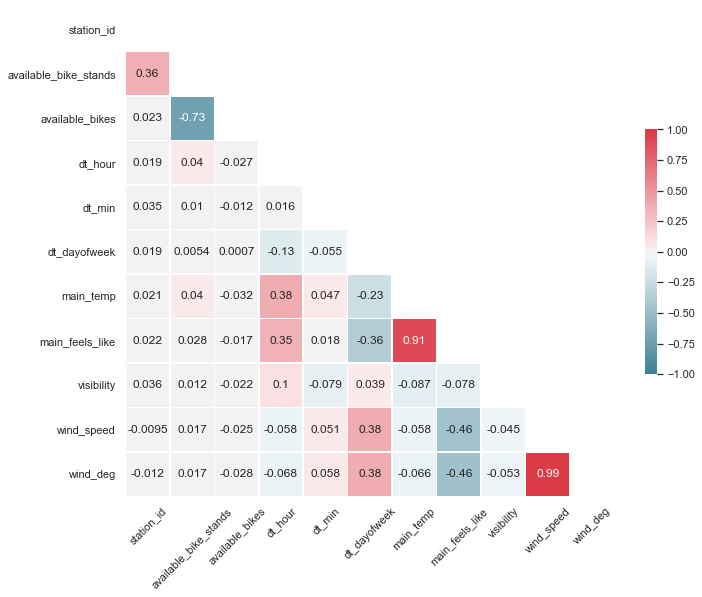

In [10]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = df_merged[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

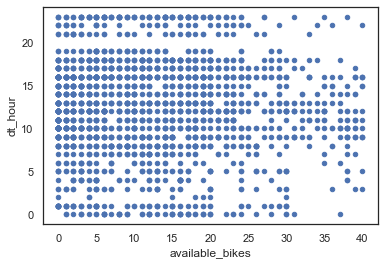

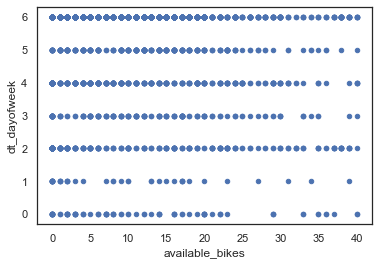

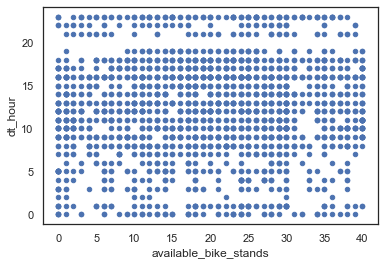

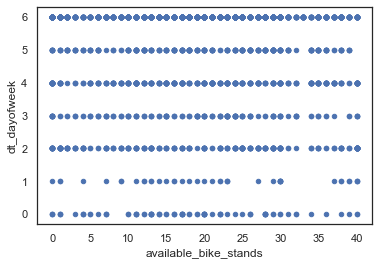

In [11]:
df_merged.plot(kind='scatter', x='available_bikes', y='dt_hour')
df_merged.plot(kind='scatter', x='available_bikes', y='dt_dayofweek')
df_merged.plot(kind='scatter', x='available_bike_stands', y='dt_hour')
df_merged.plot(kind='scatter', x='available_bike_stands', y='dt_dayofweek')

## 3.4. Correlations for the category features for all stations

<Figure size 432x288 with 0 Axes>

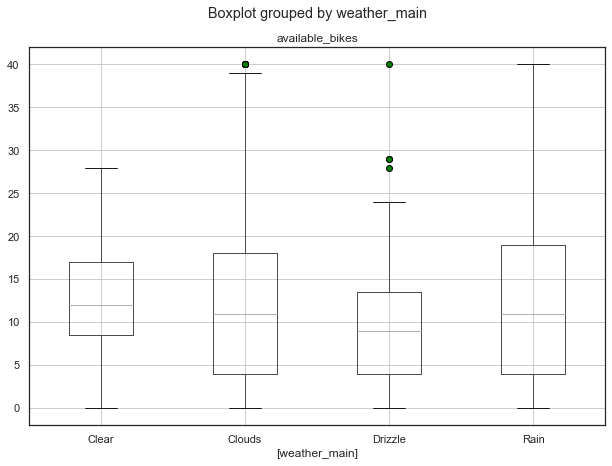

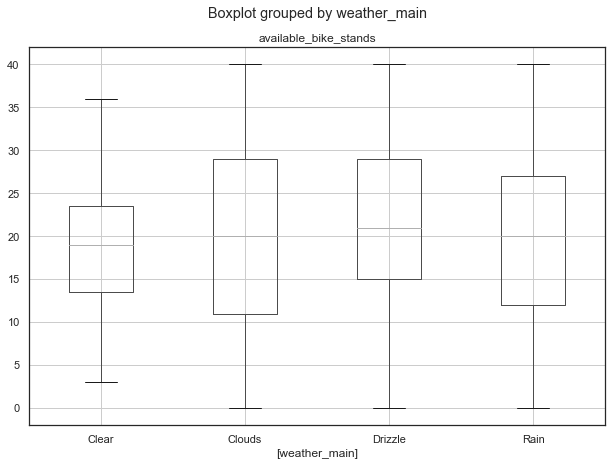

In [12]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_merged.boxplot(column=['available_bikes'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))
df_merged.boxplot(column=['available_bike_stands'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))

## 3.5. Discovery for now
From the charts above, it can be seen that if we consider all of the stations together, there is no obvious relationship between available biks/stands and other featers. So we consider a single station to explore the relationship. 

## 3.6. Correlations for the numeric features for a sigle station ( eg: station 42 )

In [13]:
df_station_42 = df_bike[df_bike['station_id']==42]
#df_bike['station_id'] == 42
df_station_42.head()

,id,station_id,status,bike_stands,available_bike_stands,available_bikes,dt,dt_hour,dt_min,dt_date,dt_dayofweek
0,1,42,OPEN,30,26,4,2020-02-27 14:05:02,14,5,2020-02-27,3
110,331,42,OPEN,30,1,29,2020-02-28 01:22:54,1,22,2020-02-28,4
330,551,42,OPEN,30,1,29,2020-02-28 01:33:03,1,33,2020-02-28,4
550,771,42,OPEN,30,1,29,2020-02-28 01:43:11,1,43,2020-02-28,4
770,991,42,OPEN,30,1,29,2020-02-28 01:53:19,1,53,2020-02-28,4


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

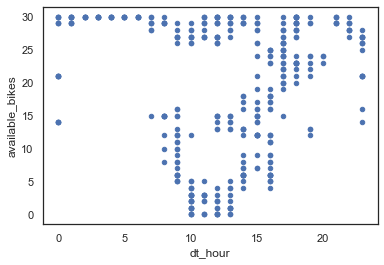

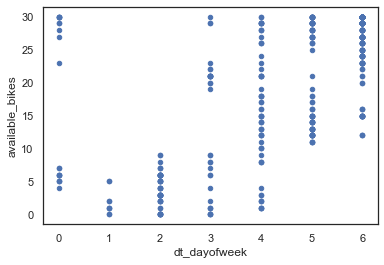

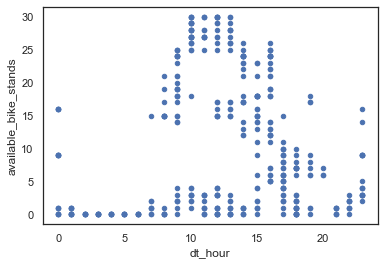

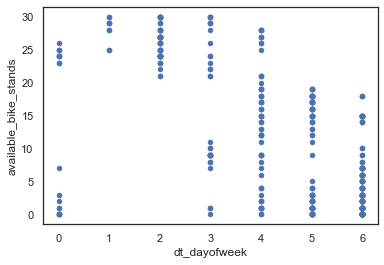

In [14]:
df_station_42.plot(kind='scatter', x='dt_hour', y='available_bikes')
df_station_42.plot(kind='scatter', x='dt_dayofweek', y='available_bikes')
df_station_42.plot(kind='scatter', x='dt_hour', y='available_bike_stands')
df_station_42.plot(kind='scatter', x='dt_dayofweek', y='available_bike_stands')

In [15]:
df_station_42 = df_merged[df_merged['station_id']==42]
#df_bike['station_id'] == 42
df_station_42.head()

,id_x,station_id,status,bike_stands,available_bike_stands,available_bikes,dt_x,dt_hour,dt_min,dt_date,...,sys_type,sys_id,sys_message,sys_country,sys_sunrise,sys_sunset,timezone,city_id,name,cod
0,331,42,OPEN,30,1,29,2020-02-28 01:22:54,1,22,2020-02-28,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
166,4291,42,OPEN,30,27,2,2020-02-28 13:51:36,13,51,2020-02-28,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
235,6711,42,OPEN,30,11,19,2020-02-28 16:51:43,16,51,2020-02-28,...,1,1565,None,IE,2020-02-28 07:16:38,2020-02-28 17:59:11,0,2964574,Dublin,200
439,11881,42,OPEN,30,3,27,2020-02-29 23:43:13,23,43,2020-02-29,...,1,1565,None,IE,2020-02-29 07:14:21,2020-02-29 18:01:06,0,2964574,Dublin,200
453,12101,42,OPEN,30,3,27,2020-02-29 23:53:21,23,53,2020-02-29,...,1,1565,None,IE,2020-02-29 07:14:21,2020-02-29 18:01:06,0,2964574,Dublin,200


## 3.7. Correlations for the category features for all stations

<Figure size 432x288 with 0 Axes>

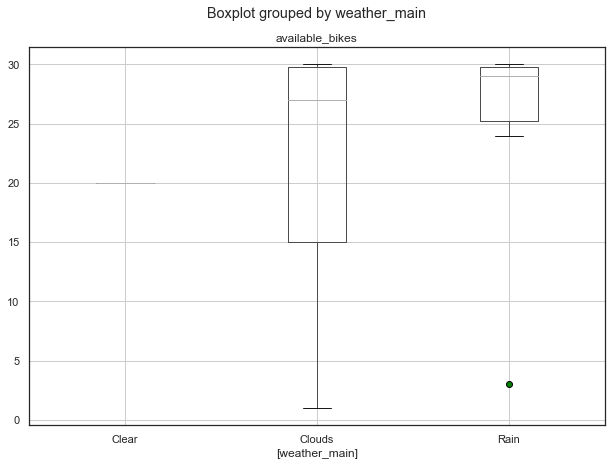

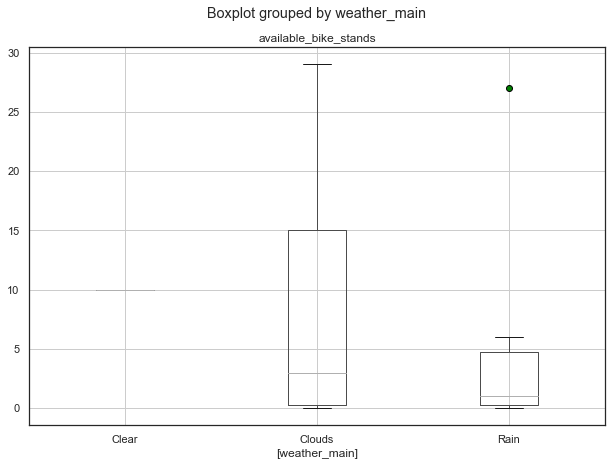

In [16]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_station_42.boxplot(column=['available_bikes'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))
df_station_42.boxplot(column=['available_bike_stands'], by=['weather_main'], flierprops=flierprops, figsize=(10,7))

## 3.8. Transform the wearther category feature into numeric feature

From the above chart, we can see that the raining factor have a major infulence. Therefore, we transform the feature into rain feature which only indicates if it rains or not.

In [17]:
df_station_42['rain'] = df_station_42.weather_main.apply(lambda x: 1 if 'Rain' in x else 0)
df_merged['rain'] = df_merged.weather_main.apply(lambda x: 1 if 'Rain' in x else 0)

D:\Software\Anaconda\Anaconda\envs\dbbikes\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# 4. ML Model

## 4.1. Model Training

In [18]:
# Select model features and store them in a new dataframe
input_data = pd.DataFrame(df_station_42[['dt_dayofweek', 'dt_hour', 'rain']])

# Define target variable
output_data = df_station_42['available_bikes']

# Split dataset to train and test
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=42)
print("Training the model on %s rows and %s columns." % x_train.shape)

lr = LinearRegression()

# Train the model
lr.fit(x_train, y_train)

print("Testing the model on %s rows." % y_test.shape[0])

Training the model on 18 rows and 3 columns.
Testing the model on 7 rows.


In [19]:
df_station_42.dtypes

id_x                              int64
station_id                        int64
status                           object
bike_stands                       int64
available_bike_stands             int64
available_bikes                   int64
dt_x                     datetime64[ns]
dt_hour                           int64
dt_min                            int64
dt_date                          object
dt_dayofweek                      int64
id_y                              int64
coord_lon                       float64
coord_lat                       float64
weather_id                        int64
weather_main                     object
weather_description              object
weather_icon                     object
base                             object
main_temp                       float64
main_feels_like                 float64
main_temp_min                   float64
main_temp_max                   float64
main_pressure                     int64
main_humidity                     int64


## 4.2 Model Testing

In [20]:
# Get prediction for test cases
prediction = lr.predict(x_test)

# Show the predicted test cases
print(prediction)
print(y_test)

[26.97469128 30.24408598 10.65253211 26.68096602 27.86983682 25.78931292
 28.46427222]
640     30
1189    24
0       29
2160    15
962     27
683     30
1082    29
Name: available_bikes, dtype: int64


## 4.3. Model Evaluation

In [21]:
print("RMSE: %f" % np.sqrt(metrics.mean_squared_error(y_test, prediction)))

RMSE: 8.783012


## 4.4. Discovery so far
We can see that the model for a single station will have a good prediction result. So we generate model for each station.

## 4.5. Create model for each station and Model Serialising

In [22]:
import pickle

id_list = list(df_merged['station_id'].unique())
for station_id in id_list:
    df_station = df_merged[df_merged['station_id']==station_id]
    
    # Select model features and store them in a new dataframe
    input_data = pd.DataFrame(df_station[['dt_dayofweek', 'dt_hour', 'rain']])

    # Define target variable
    output_data = df_station['available_bikes']

    # Split dataset to train and test
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.25, random_state=42)

    lr = LinearRegression()

    # Train the model
    lr.fit(x_train, y_train)
    
    with open('./models/' + str(station_id) + '_station_model.pkl', 'wb') as handle:
        pickle.dump(lr, handle, pickle.HIGHEST_PROTOCOL)